# Test the two-line CLEDB inversion on data.

The script version "test_2line.py" is generated by exporting this notebook via file -> export as -> executable script. Do not directly edit that version!

In [1]:
## Inversion Constants and control parameter imports.
import constants as consts
import ctrlparams
params=ctrlparams.ctrlparams()    ##Initialize and use a shorter label

## Needed modules
import importlib                  ## Reloads imports (python default settings will not reload small changes).
import numpy as np                ## Defines variables to store/load headers
from astropy.io import fits       ## To properly load DKISt Cryo-NIRSP data


### 1. Import the Fe XIII 1074 nm and 1079 nm synthetic CLE/MURAM or observed MLSO CoMP or DKIST Cryo-NIRSP data

#### 1.a CLE 3dipole along LOS simulation example

In [2]:
# ## observations of a 3 dipole coronal structure of a Fe XIII combined observation
# ## sobs1-3 are the independent dipoles
# ## sobsa is the combined 3 dipole output
# ## waveA and waveB are the wavelength arrays for the two Fe XIII lines

# sobs1,sobs2,sobs3,sobsa,waveA,waveB = np.load('obsstokes_3dipole_hires_fullspectra_1kg.pkl', allow_pickle=True) ## Generally returns a 1 element list, unpack via [0]

# ### reversing of the wavelength range. THIS IS NEEDED! CLE writes frequency-wise, so wavelengths are reversed in the original datacubes!!!!!!
# sobsa=sobsa[:,:,::-1,:]
# #waveA=waveA[::-1]         ##the wave arrays are not needed by the inversion. the information is reconstructed from keywords
# #waveB=waveB[::-1]

# if params.integrated == False:
#     sobs_in=[sobsa[:,:,:,0:4],sobsa[:,:,:,4:8]]   ## The simulated data is a x*y*wl*8 dimensional array with both lines included.  ## create a 2line standard input for an actual observation.

# ## A fake minimal header for CLE
# ## This assumes the reference pixel is in the left bottom of the array; the values are in solar coordinates at crpixn in r_sun. The wavelength raferences (vacuum), ranges and spectral resolutions are unique. See CLE outfiles and grid.dat.
# ## sobsa.shape == (600, 280, 30, 8)
# head_in =[{'CRPIX1':0, 'CRPIX2':0, 'CRPIX3': 14, 'CRVAL1': -0.75, 'CRVAL2': 0.8, 'CRVAL3': 1074.61446, 'CDELT1': (0.75-(-0.75))/600, 'CDELT2': (1.5-0.8)/280, 'CDELT3': 0.0247, 'LINEWAV': "1074", 'INSTRUME': "CLE-SIM"},\
#           {'CRPIX1':0, 'CRPIX2':0, 'CRPIX3': 14, 'CRVAL1': -0.75, 'CRVAL2': 0.8, 'CRVAL3': 1079.76807, 'CDELT1': (0.75-(-0.75))/600, 'CDELT2': (1.5-0.8)/280, 'CDELT3': 0.0247, 'LINEWAV': "1079", 'INSTRUME': "CLE-SIM"}]

# ## Delete the large arrays from memory
# sobsa = 0

# ## The Numba non-python cledb_prepinv implmentation needs static inputs, that forces including sobs_dopp for hypotethically running iqud setups.
# ## In the IQUV case, the array is just set to empty and will not be used.
# if params.iqud == False:
#     sobs_dopp = np.empty((sobs_in[0].shape[0],sobs_in[0].shape[1],4),dtype=np.float32)

#### 2.a MURAM data example loading

In [3]:
## load the fake observation muram data
## FE XIII 1074+1079

# with open('obsstokes_avg_muram3.pkl','rb') as f:
#     sobsa = pickle.load(f)
sobsa=np.load('obsstokes_avg_muram3.pkl', allow_pickle=True)[0] ## Generally returns a 1 element list, unpack via [0]

if params.integrated == False:
    sobs_in=[sobsa[:,:,:,0:4],sobsa[:,:,:,4:8]]   ## The simulated data is a x*y*wl*8 dimensional array with both lines included.  ## create a 2line standard input for an actual observation.  

# ## A fake minimal header for MURAM
# ## This assumes the reference pixel is in the left bottom of the array; the values are in solar coordinates at crpixn in r_sun (from muram xvec and yvec arrays). The wavelength raferences (vacuum), ranges and spectral resolutions are unique (muram wvvec1 and wvvce2 arrays).
head_in =[{'CRPIX1':0, 'CRPIX2':0, 'CRPIX3':0, 'CRVAL1': -0.071, 'CRVAL2': 0.989, 'CRVAL3': 1074.257137, 'CDELT1': 0.0001379, 'CDELT2':  0.0000689, 'CDELT3': 0.0071641, 'LINEWAV': "1074", 'INSTRUME': "MUR-SIM"},\
          {'CRPIX1':0, 'CRPIX2':0, 'CRPIX3':0, 'CRVAL1': -0.071, 'CRVAL2': 0.989, 'CRVAL3': 1079.420513, 'CDELT1': 0.0001379, 'CDELT2':  0.0000689, 'CDELT3': 0.0071985, 'LINEWAV': "1079", 'INSTRUME': "MUR-SIM"}]

## Delete the large arrays from memory
sobsa = 0

## The Numba non-python cledb_prepinv implmentation needs static inputs, that forces including sobs_dopp for hypotethically running iqud setups.
## In the IQUV case, the array is just set to empty and will not be used.
if params.iqud == False:
    sobs_dopp = np.empty((sobs_in[0].shape[0],sobs_in[0].shape[1],4),dtype=np.float32)

# ## muram data too big to include as test data!!!!

#### 3.a DKIST Cryo-NIRSP Provisional example data (Integrated required).

In [4]:
# import dkist                      ## Optionally needed only if loading DKIST data
# if params.integrated == True:
#     ##Loads the observation metadata into memory. Unique datasets are preserved here.
#     asdf_file_1 = './obsstokes_cryonirsp_L1_BZJOM_metadata.asdf'    ## raster dataset - 1074
#     asdf_file_2 = './obsstokes_cryonirsp_L1_BXEMJ_metadata.asdf'    ## raster dataset - 1079
#     head_in = [dkist.load_dataset(asdf_file_1).headers, dkist.load_dataset(asdf_file_2).headers]   ### list of two headers


#     sobsa = np.zeros((head_in[0][0]['CNNUMSCN'],head_in[0][0]['DNAXIS2'],4),dtype=np.float32) ## sobsa will not have a wavelength point dimension in this case
#     sobsb = np.zeros((head_in[0][0]['CNNUMSCN'],head_in[0][0]['DNAXIS2'],4),dtype=np.float32)

#     sobsa   = np.load('./obsstokes_cryonirsp_BZJOM_int1074')    ## 1074 fit data
#     sobsb   = np.load('./obsstokes_cryonirsp_BXEMJ_int1079')    ## 1079 fit data
#     sobs_in=[sobsa,sobsb]   ## The Xryo-NIRSP data is a x*y*wl*4 dimensional array with one lines included.  ## create a 2line standard input for an actual observation.  


# ## Delete the large arrays from memory
# sobsa = 0

# ## The Numba non-python cledb_prepinv implmentation needs static inputs, that forces including sobs_dopp for hypotethically running iqud setups.
# ## In the IQUV case, the array is just set to empty and will not be used.
# if params.iqud == False:
#     sobs_dopp = np.empty((sobs_in[0].shape[0],sobs_in[0].shape[1],4),dtype=np.float32)


#### 4.a - 4.b CoMP line integrated data example loading (IQUD required. No Stokes V!)

In [5]:
# ## load a sample MLSO CoMP observation.
# ## FE XIII 1074+1079
# ## We will be using the 20120327 continuum corrected CoMP datacube from http://download.hao.ucar.edu/d5/mlso/pub/comp-continuum-correction/
# ## MLSO lev-2 data that are already wavelength integrated.

# ## Practically, in this test case both iqud and integrated parameters need to be set to true.

# c1074_iqu,c1079_iqu = sobsa=np.load('obsstokes_CoMP_integrated_20120327.pkl', allow_pickle=True)

# head_in = [c1074_iqu['index1'],c1079_iqu['index1']]

# sobsa = np.zeros((head_in[0].naxis1[0],head_in[0].naxis2[0],4),dtype=np.float32) ## sobsa will not have a wavelength point dimension in this case
# sobsb = np.zeros((head_in[0].naxis1[0],head_in[0].naxis2[0],4),dtype=np.float32)

# ## This examples uses frames "3" in the c1074_iqu cube and "2"in the c1079_iqu cube which are close temporally for the main matching
# sobsa[:,:,0] = c1074_iqu['cube_ii'][3,:,:]                       ## Uses frame 3 - '2012-03-27T18:01:21'
# sobsa[:,:,1] = c1074_iqu['cube_q' ][3,:,:]
# sobsa[:,:,2] = c1074_iqu['cube_u' ][3,:,:]

# sobsb[:,:,0] = c1079_iqu['cube_ii'][2,:,:]                       ## Uses frame 2 - '2012-03-27T18:05:32'
# sobsb[:,:,1] = c1079_iqu['cube_q' ][2,:,:]
# sobsb[:,:,2] = c1079_iqu['cube_u' ][2,:,:]


# ## If future uCoMP or COSMO data can retrieve Stokes V, an IQUV inversion might become feasible
# ## Otherwise just leave the Stokes V dimension set to 0
# # if params.iqud != True:
# #     sobsa[:,:,3] = c1074_iqu['cube_v'][3,:,:]                    ##cube_v does not exist in this test dataset
# #     sobsb[:,:,3] = c1079_iqu['cube_v'][3,:,:]

# if params.integrated == True:
#     sobs_in=[sobsa,sobsb   ## The CoMP/uCoMP data is a x*y*4 dimensional array with both lines included.  ## create a 2line standard input for an actual observation.  

# ## Delete the large arrays from memory
# sobsa = 0
# sobsb = 0

# ## Loading of the doppler data.
# if params.integrated == True and params.iqud == True:
#     sobs_dopp = np.nan_to_num(np.load('obsdopp_CoMP_IQUD_bpos_20120327.pkl', allow_pickle=True)[0],nan=0)    ## lots of voxels were deemed unmeasurable and are stored as nan. Convert these to 0 for simplicity.

# ## These quantities are computed using the methods and public code presented in Yang et. al, 2020
# ## The array dimensions are:
# ## 0 - Magnetic field strength via wave plasma speed (see Paraschiv 2023 or Yang et. al, 2020)
# ## The quantity might alternatively be assumed as correspondent correspondent to B*cos(Theta_B). The applicability of this statement is not yet proved!!
# ## 1 - Not directly used - Wave propagation angle (wpa) resulting from the doppler oscilation analysis. ## - np.pi/2 applied,
# ##     (wpa): If using the IDL scripts to compute these quantities, deduct pi/2 to have the same range as 0.5arctan(u/q) which is (-pi/2,pi/2).
# ## 2 - Not directly used - Magnetic azimuth as derived from the ratio of the UQ linear polarization components (Phi_B; also computed in this setup). sobs_dopp[2]=sobs_dopp[0]*np.cos(Phi_B)
# ## 3 - Not directly used - Magnetic azimuth as derived from the wave phase angle(wpa) of propagating doppler waves.                                  sobs_dopp[3]=sobs_dopp[0]*np.cos(sobs_dopp[1])

### 2. Test the CLEDB_PREPINV module with synthetic data. 

##### Remember to set your personal options and database paths in the ctrlparams class (in the parent directory) before continuing.

In [6]:
import CLEDB_PREPINV.CLEDB_PREPINV as prepinv  ##imports from the CLEDB_PREPINV subdirectory

##### Preprocess the observation "files".

In [7]:
importlib.reload(prepinv)       ## If module is modified, reload the contents
sobs_tot,yobs,snr,background,issuemask,wlarr,keyvals,sobs_totrot,aobs,dobs=prepinv.sobs_preprocess(sobs_in,head_in,params)

------------------------------------
----SOBS_PREPROCESS - READ START----
------------------------------------
Inverting observations of 2 coronal line(s) 
Line 1: Fe XIII 1074.7nm
Line 2: Fe XIII 1079.8nm
OBS_INTEGRATE: Integrating the Stokes IQUV spectra:


100%|█████████████████████████████████████████████████████████████████████████████████████| 2097152/2097152 [00:50<00:00, 41269.42it/s]


OBS_DENS: Calculating observation LOS plasma density:


100%|████████████████████████████████████████████████████████████████████████████████████| 1048576/1048576 [00:09<00:00, 109454.77it/s]


95.486971  SECONDS FOR TOTAL OBS PREPROCESS INTEGRATION AND ROTATION
------------------------------------
--SOBS_PREPROCESS - READ FINALIZED--
------------------------------------


##### Select and pre-read the database files based on the observation preprocessing. At this point, the database should be generated via CLEDB_BUILD and properly path linked via ctrlparams.

In [8]:
keyvals

[1024,
 1024,
 101,
 2,
 ['fe-xiii_1074', 'fe-xiii_1079'],
 0,
 0,
 [np.int32(0), np.int32(0)],
 np.float32(-0.071),
 np.float32(0.989),
 [np.float32(1074.2571), np.float32(1079.4205)],
 np.float32(0.0001379),
 np.float32(6.89e-05),
 [np.float32(0.0071641), np.float32(0.0071985)],
 0,
 0]

In [ ]:
importlib.reload(prepinv)       ## If module is modified, reload the contents
db_enc,database,dbhdr=prepinv.sdb_preprocess(yobs,dobs,keyvals,wlarr,params)  ## Warning, this might be memory consuming; see details in documentation

------------------------------------
----SDB_PREPROCESS - READ START-----
------------------------------------
SDB_PREPROCESS: Matching optimal database based on elongation and density:


100%|████████████████████████████████████████████████████████████████████████████████████| 1048576/1048576 [00:06<00:00, 157641.54it/s]


Available CLEDB databases cover a span of 99 solar heights between 1.01 - 2.0  radius
Load  247  heights x densities  DB datafiles in memory for each of  2 line(s).
------------------------------------
INDIVIDUAL DB file location: ./CLEDB_BUILD/fe-xiii_1074/DB_h101_d1000.npy
INDIVIDUAL DB file location: ./CLEDB_BUILD/fe-xiii_1079/DB_h101_d1000.npy
INDIVIDUAL DB file location: ./CLEDB_BUILD/fe-xiii_1074/DB_h101_d1005.npy
INDIVIDUAL DB file location: ./CLEDB_BUILD/fe-xiii_1079/DB_h101_d1005.npy
INDIVIDUAL DB file location: ./CLEDB_BUILD/fe-xiii_1074/DB_h101_d1010.npy
INDIVIDUAL DB file location: ./CLEDB_BUILD/fe-xiii_1079/DB_h101_d1010.npy
INDIVIDUAL DB file location: ./CLEDB_BUILD/fe-xiii_1074/DB_h101_d1015.npy
INDIVIDUAL DB file location: ./CLEDB_BUILD/fe-xiii_1079/DB_h101_d1015.npy
INDIVIDUAL DB file location: ./CLEDB_BUILD/fe-xiii_1074/DB_h101_d1020.npy
INDIVIDUAL DB file location: ./CLEDB_BUILD/fe-xiii_1079/DB_h101_d1020.npy
INDIVIDUAL DB file location: ./CLEDB_BUILD/fe-xiii_1074/DB

#### At this point all necesary data and required databases are loaded into memory for fast processing.

### 3. Test the CLEDB_PROC module with the same synthetic data.

In [14]:
import CLEDB_PROC.CLEDB_PROC as procinv

##### Process the spectroscopy outputs

In [15]:
importlib.reload(procinv)                               ## If module is modified, reload the contents
specout = procinv.spectro_proc(sobs_in,sobs_tot,snr,issuemask,background,wlarr,keyvals,consts,params)

--------------------------------------
---SPECTRO_PROC - SPECTROSCOPY START--
--------------------------------------
SPECTRO_PROC: calculating spectroscopic line products for fe-xiii_1074:


/data/arparaschiv/solar-coronal-inversion/CLEDB_PROC/CLEDB_PROC.py:865: RuntimeWarning: overflow encountered in scalar power066.37it/s]
  spec_1pix[11] = np.sqrt(sobs_tot_1pix[1]**2+sobs_tot_1pix[2]**2+sobs_tot_1pix[3]**2) / sobs_tot_1pix[0]  ## fraction of total polarization with respect to intensity
/data/arparaschiv/solar-coronal-inversion/CLEDB_PROC/CLEDB_PROC.py:865: RuntimeWarning: overflow encountered in scalar power641.46it/s]
  spec_1pix[11] = np.sqrt(sobs_tot_1pix[1]**2+sobs_tot_1pix[2]**2+sobs_tot_1pix[3]**2) / sobs_tot_1pix[0]  ## fraction of total polarization with respect to intensity
100%|█████████████████████████████████████████████████████████████████████████████████████| 1048576/1048576 [00:47<00:00, 22196.37it/s]


SPECTRO_PROC: calculating spectroscopic line products for fe-xiii_1079:


100%|█████████████████████████████████████████████████████████████████████████████████████| 1048576/1048576 [00:47<00:00, 22289.85it/s]


129.942803  SECONDS FOR TOTAL SPECTROSCOPY PROCESSING
--------------------------------------
-SPECTRO_PROC - SPECTROSCOPY FINALIZED
--------------------------------------


##### Process the LOS magnetic fields from the first line

In [12]:
importlib.reload(procinv)       ## If module is modified, reload the contents
blosout=procinv.blos_proc(sobs_tot,snr,issuemask,keyvals,consts,params)

--------------------------------------
---BLOS_PROC: B LOS ESTIMATION START--
--------------------------------------
BLOS_PROC: Calculating LOS Magnetic Field projection for fe-xiii_1074:


100%|██████████████████████████████████████████████████████████████████████████████████████| 168000/168000 [00:00<00:00, 194095.48it/s]


BLOS_PROC: Calculating LOS Magnetic Field projection for fe-xiii_1079:


/data/arparaschiv/solar-coronal-inversion/CLEDB_PROC/CLEDB_PROC.py:889: RuntimeWarning: overflow encountered in scalar multiply.39it/s]
  blos1[0] = (const.planckconst/const.bohrmagneton*const.l_speed*1.e9/(const.line_ref**2)) *\
/data/arparaschiv/solar-coronal-inversion/CLEDB_PROC/CLEDB_PROC.py:892: RuntimeWarning: overflow encountered in scalar multiply
  blos1[1] = (const.planckconst/const.bohrmagneton*const.l_speed*1.e9/(const.line_ref**2)) *\
/data/arparaschiv/solar-coronal-inversion/CLEDB_PROC/CLEDB_PROC.py:895: RuntimeWarning: overflow encountered in scalar multiply
  blos1[2] = (const.planckconst/const.bohrmagneton*const.l_speed*1.e9/(const.line_ref**2)) *\
/data/arparaschiv/solar-coronal-inversion/CLEDB_PROC/CLEDB_PROC.py:889: RuntimeWarning: overflow encountered in scalar multiply
  blos1[0] = (const.planckconst/const.bohrmagneton*const.l_speed*1.e9/(const.line_ref**2)) *\
/data/arparaschiv/solar-coronal-inversion/CLEDB_PROC/CLEDB_PROC.py:892: RuntimeWarning: overflow encount

6.006772  SECONDS FOR TOTAL BLOS PROCESSING
--------------------------------------
-BLOS_PROC: BLOS ESTIMATION FINALIZED-
--------------------------------------


##### Process the full vector magnetic field inversion products

In [58]:
## WARNING: This step has a significantly long execution time.
importlib.reload(procinv)       ## If module is modified, reload the contents
invout,sfound=procinv.cledb_invproc(sobs_totrot,sobs_dopp,database,db_enc,yobs,aobs,dobs,snr,issuemask,dbhdr,keyvals,params.nsearch,params.maxchisq,params.bcalc,params.iqud,params.ncpu,params.reduced,params.verbose)

## To enable timing of this function when verbose >= 2, use it via its wrapper. See comments.
#invout,sfound=procinv.cledb_invproc_time(sobs_totrot,sobs_dopp,database,db_enc,yobs,aobs,dobs,snr,issuemask,dbhdr,keyvals,params.nsearch,params.maxchisq,params.bcalc,params.iqud,params.ncpu,params.reduced,params.verbose)

--------------------------------------
----CLEDB_INVPROC - INVERSION START---
--------------------------------------
CLEDB_INVPROC: Using a full database search of size: 41164200
CLEDB_INVPROC: Finding full Stokes IQUV database matches:


100%|█████████████████████████████████████████████████████████████████████████████████████████| 168000/168000 [03:28<00:00, 804.24it/s]


--------------------------------------
--CLEDB_INVPROC - INVERSION FINALIZED-
--------------------------------------


### All should be good if we reached this point; all the outputs should be computed and saved in memory.

## 4. OPTIONAL tidbits

In [16]:
##optionally needed libraries and functions

from datetime import datetime
import os
import glob
import pickle
import numpy as np

from matplotlib import pyplot as plt
## interactive plotting; use only on local machines if widget is installed
%matplotlib widget

# colorbar function to have nice colorbars in figures with title
def colorbar(mappable,*args,**kwargs):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax,format='%.3f')
    #cbar.formatter.set_powerlimits((0, 0))
    title= kwargs.get('title', None)
    cbar.set_label(title)
    plt.sca(last_axes)
    return cbar

### 4.a DUMP results (optional)

In [18]:
## Remove old file saves and keep just the last run
lst=glob.glob('./outparams_2line*.pkl')
if len(lst) >0:
    for i in range(len(lst)):
        os.remove(lst[i])

## save the last run
datestamp = datetime.now().strftime("%Y%m%d-%H:%M:%S")

# if not os.path.exists('./testrun_outputs'):               ## make an output directory to keep things clean
#     os.makedirs('./testrun_outputs')

# if os.path.isfile(f"testrun_outputs/outparams_2line_{datestamp}.pkl"):
#     print("Save data exists; Are you sure you want to overwrite?")
# else:
#     if params.iqud == False:                              ## all outputs saved to disk
#         with open(f'./testrun_outputs/outparams_2line_{datestamp}.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#             pickle.dump([specout,blosout,invout,sfound], f)
#     else:                                                 ## no specout and blosout for iqud
#         with open(f'./testrun_outputs/outparams_2line_{datestamp}.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
#             pickle.dump([invout,sfound], f)

### 4.b PLOT the outputs (optional)

In [20]:
## Plot utils

linen=0               ## choose which line to plot; range is [0:1] for 2 line input

# # plot subranges for some input snapshots
# # 3dipole
# srx1=230
# srx2=400
# sry1=65
# sry2=195
# rnge=[0.8,1.5,-1.1,1.1]

#muram      ## muram data not offered as part of the test scripts due to large sizes.
srx1=0
srx2=1024
sry1=0
sry2=1024
rnge=[0.989,1.060,-0.071,0.071]

# #CoMP
# srx1=0
# srx2=620
# sry1=0
# sry2=620
# rnge=[-1.384,1.384,-1.384,1.384]

# # #uCoMP
# srx1=0
# srx2=1024
# sry1=0
# sry2=1280
# rnge=[-1.942,1.942,-1.553,1.553]

### Plot spectroscopy outputs

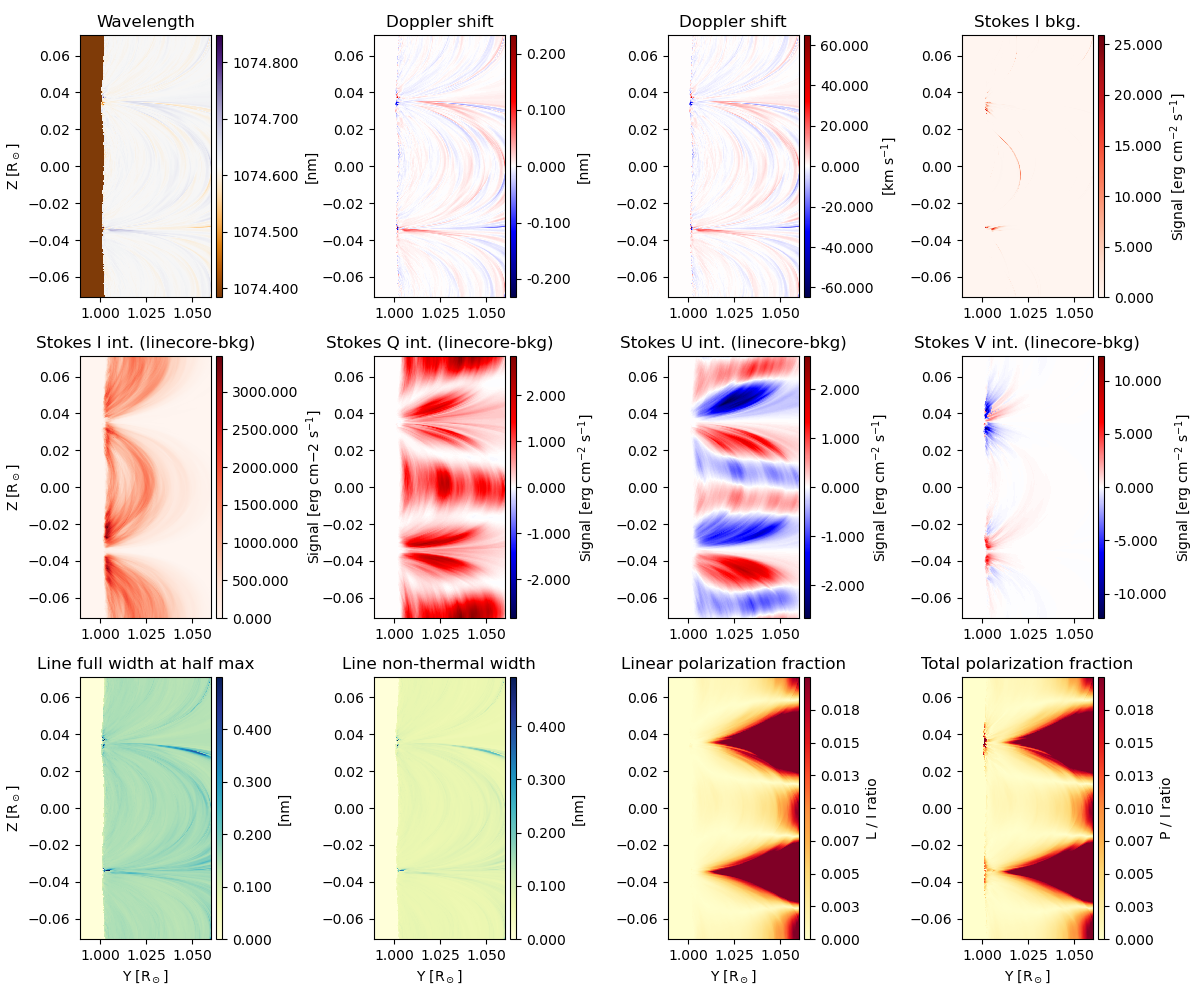

In [21]:
fig, plots = plt.subplots(nrows=3, ncols=4, figsize=(12,10))


## remove the 0 values and unreasonable/outlier values outside of the range of the four lines.
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,0], mask=specout[srx1:srx2,sry1:sry2,linen,0]==0)
mx = np.ma.masked_array(mx, mask=specout[srx1:srx2,sry1:sry2,linen,0]>= 3950)
mx = np.ma.masked_array(mx, mask=specout[srx1:srx2,sry1:sry2,linen,0]<= 1070)
vvmin=np.min(mx)
vvmax=np.max(mx)
ab=plots[0,0].imshow(specout[srx1:srx2,sry1:sry2,linen,0],extent=rnge,origin='lower',vmin=vvmin,vmax=vvmax,cmap='PuOr',interpolation='none')
plots[0,0].set_title('Wavelength')
colorbar(ab,title="[nm]")
plots[0,0].set_ylabel('Z [R$_\odot$]')
#plots[0,0].set_xlabel('Y [R$_\odot$]')
############################################################


## for correctly scaling in doppler scales # remove unreasonable/outlier values of > 2 nm.
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,1], mask=specout[srx1:srx2,sry1:sry2,linen,1]>= 2 )
mx = np.ma.masked_array(mx, mask=specout[srx1:srx2,sry1:sry2,linen,1]<= -2 )
vvmax=np.max(mx)
vvmin=np.min(mx)
if np.abs(vvmin) >  np.abs(vvmax):
    vr=np.abs(vvmin)
else:
    vr=np.abs(vvmax)
ab=plots[0,1].imshow(specout[srx1:srx2,sry1:sry2,linen,1],extent=rnge,origin='lower',vmin=-vr,vmax=vr,cmap='seismic',interpolation='none')
plots[0,1].set_title('Doppler shift')
colorbar(ab,title="[nm]")
#plots[0,1].set_ylabel('Z [R$_\odot$]')
#plots[0,1].set_xlabel('Y [R$_\odot$]')
############################################################


## for correctly scaling in speed scales # remove unreasonable/outlier values of > 1000km/s.
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,2], mask=specout[srx1:srx2,sry1:sry2,linen,2]>= 1000 )
mx = np.ma.masked_array(mx, mask=specout[srx1:srx2,sry1:sry2,linen,2]<= -1000 )
vvmax=np.max(mx)
vvmin=np.min(mx)
if np.abs(vvmin) >  np.abs(vvmax):
    vr=np.abs(vvmin)
else:
    vr=np.abs(vvmax)
## back to plotting
ab=plots[0,2].imshow(specout[srx1:srx2,sry1:sry2,linen,2],extent=rnge,origin='lower',vmin=-vr,vmax=vr,cmap='seismic',interpolation='none')
plots[0,2].set_title('Doppler shift')
colorbar(ab,title="[km s$^{-1}$]")
#plots[0,2].set_ylabel('Z [R$_\odot$]')
#plots[0,2].set_xlabel('Y [R$_\odot$]')
############################################################


ab=plots[0,3].imshow(specout[srx1:srx2,sry1:sry2,linen,7],extent=rnge,origin='lower',vmin=0,vmax=np.max(specout[srx1:srx2,sry1:sry2,linen,7]),cmap='Reds',interpolation='none')
plots[0,3].set_title('Stokes I bkg.')
colorbar(ab,title="Signal [erg cm$^{-2}$ s$^{-1}$]")
#plots[0,3].set_ylabel('Z [R$_\odot$]')
#plots[0,3].set_xlabel('Y [R$_\odot$]')
############################################################


ab=plots[1,0].imshow(specout[srx1:srx2,sry1:sry2,linen,3],extent=rnge,origin='lower',vmin=0,vmax=np.max(specout[srx1:srx2,sry1:sry2,linen,3]),cmap='Reds',interpolation='none')
plots[1,0].set_title('Stokes I int. (linecore-bkg)')
colorbar(ab,title="Signal [erg cm${-2}$ s$^{-1}$]")
plots[1,0].set_ylabel('Z [R$_\odot$]')
#plots[1,0].set_xlabel('Y [R$_\odot$]')
############################################################


vvmin=np.min(specout[srx1:srx2,sry1:sry2,linen,4])
vvmax=np.max(specout[srx1:srx2,sry1:sry2,linen,4])
if np.abs(vvmin) >  np.abs(vvmax):
    vr=np.abs(vvmin)
else:
    vr=np.abs(vvmax)
ab=plots[1,1].imshow(specout[srx1:srx2,sry1:sry2,linen,4],extent=rnge,origin='lower',vmin=-vr,vmax=vr,cmap='seismic',interpolation='none')
plots[1,1].set_title('Stokes Q int. (linecore-bkg)')
colorbar(ab,title="Signal [erg cm$^{-2}$ s$^{-1}$]")
#plots[1,1].set_ylabel('Z [R$_\odot$]')
#plots[1,1].set_xlabel('Y [R$_\odot$]')
############################################################


vvmin=np.min(specout[srx1:srx2,sry1:sry2,linen,5])
vvmax=np.max(specout[srx1:srx2,sry1:sry2,linen,5])
if np.abs(vvmin) >  np.abs(vvmax):
    vr=np.abs(vvmin)
else:
    vr=np.abs(vvmax)
ab=plots[1,2].imshow(specout[srx1:srx2,sry1:sry2,linen,5],extent=rnge,origin='lower',vmin=-vr,vmax=vr,cmap='seismic',interpolation='none')
plots[1,2].set_title('Stokes U int. (linecore-bkg)')
colorbar(ab,title="Signal [erg cm$^{-2}$ s$^{-1}$]")
#plots[1,2].set_ylabel('Z [R$_\odot$]')
#plots[1,2].set_xlabel('Y [R$_\odot$]')
############################################################


vvmin=np.min(specout[srx1:srx2,sry1:sry2,linen,6])
vvmax=np.max(specout[srx1:srx2,sry1:sry2,linen,6])
if np.abs(vvmin) >  np.abs(vvmax):
    vr=np.abs(vvmin)
else:
    vr=np.abs(vvmax)
ab=plots[1,3].imshow(specout[srx1:srx2,sry1:sry2,linen,6],extent=rnge,origin='lower',vmin=-vr,vmax=vr,cmap='seismic',interpolation='none')
plots[1,3].set_title('Stokes V int. (linecore-bkg)')
colorbar(ab,title="Signal [erg cm$^{-2}$ s$^{-1}$ nm$^{-1}$]")
#plots[1,3].set_ylabel('Z [R$_\odot$]')
#plots[1,3].set_xlabel('Y [R$_\odot$]')
############################################################


## remove unreasonable/outlier values from plotting range. Typical Fe XIII widths are 0.15. Outliers <0.5 are excluded from scaling.
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,8], mask=specout[srx1:srx2,sry1:sry2,linen,8] >= 0.50 )
vvmax=np.max(mx)
ab=plots[2,0].imshow(specout[srx1:srx2,sry1:sry2,linen,8],extent=rnge,origin='lower',vmin=0.0,vmax=vvmax,cmap='YlGnBu',interpolation='none')
plots[2,0].set_title('Line full width at half max')
colorbar(ab,title="[nm]")
plots[2,0].set_ylabel('Z [R$_\odot$]')
plots[2,0].set_xlabel('Y [R$_\odot$]')
############################################################


## remove unreasonable/outlier values from plotting range. Typical Fe XIII widths are 0.15. Outliers > 0.5 are excluded from scaling.
## PLOT INSIDE THE SAME SUBRANGES AS FULL WIDTHS above.
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,9], mask=specout[srx1:srx2,sry1:sry2,linen,9] >= 0.50 )
vvmax=np.nanmax(mx)
ab=plots[2,1].imshow(specout[srx1:srx2,sry1:sry2,linen,9],extent=rnge,origin='lower',vmin=0.0,vmax=vvmax,cmap='YlGnBu',interpolation='none')
plots[2,1].set_title('Line non-thermal width')
colorbar(ab,title="[nm]")
#plots[2,1].set_ylabel('Z [R$_\odot$]')
plots[2,1].set_xlabel('Y [R$_\odot$]')
############################################################


## remove unreasonable/outlier values from plotting range. These should be a small addition to the total line widths. Change the 0.02 range as seems fit.
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,10], mask=specout[srx1:srx2,sry1:sry2,linen,10] >= 0.020 )
vvmax=np.nanmax(mx)
ab=plots[2,2].imshow(specout[srx1:srx2,sry1:sry2,linen,10],extent=rnge,origin='lower',vmin=0.0,vmax=vvmax,cmap='YlOrRd',interpolation='none')
plots[2,2].set_title('Linear polarization fraction')
colorbar(ab,title="L / I ratio")
#plots[0,0].set_ylabel('Z [R$_\odot$]')
plots[2,2].set_xlabel('Y [R$_\odot$]')
############################################################


## remove unreasonable/outlier values from plotting range. These should be a small addition to the total line widths. Change the 0.02 range as seems fit.
mx = np.ma.masked_array(specout[srx1:srx2,sry1:sry2,linen,11], mask=specout[srx1:srx2,sry1:sry2,linen,11] >= 0.020 )
vvmax=np.nanmax(mx)
ab=plots[2,3].imshow(specout[srx1:srx2,sry1:sry2,linen,11],extent=rnge,origin='lower',vmin=0.0,vmax=vvmax,cmap='YlOrRd',interpolation='none')
plots[2,3].set_title('Total polarization fraction')
colorbar(ab,title="P / I ratio")
#plots[2,3].set_ylabel('Z [R$_\odot$]')
plots[2,3].set_xlabel('Y [R$_\odot$]')
############################################################


plt.tight_layout()
### Save the putput plots
if not os.path.exists('./testrun_outputs'):               ## make an output directory to keep things clean
    os.makedirs('./testrun_outputs')
plt.savefig(f"./testrun_outputs/specout_1line_line{linen}_{datestamp}.pdf")

### plot 1-line BLOS outputs

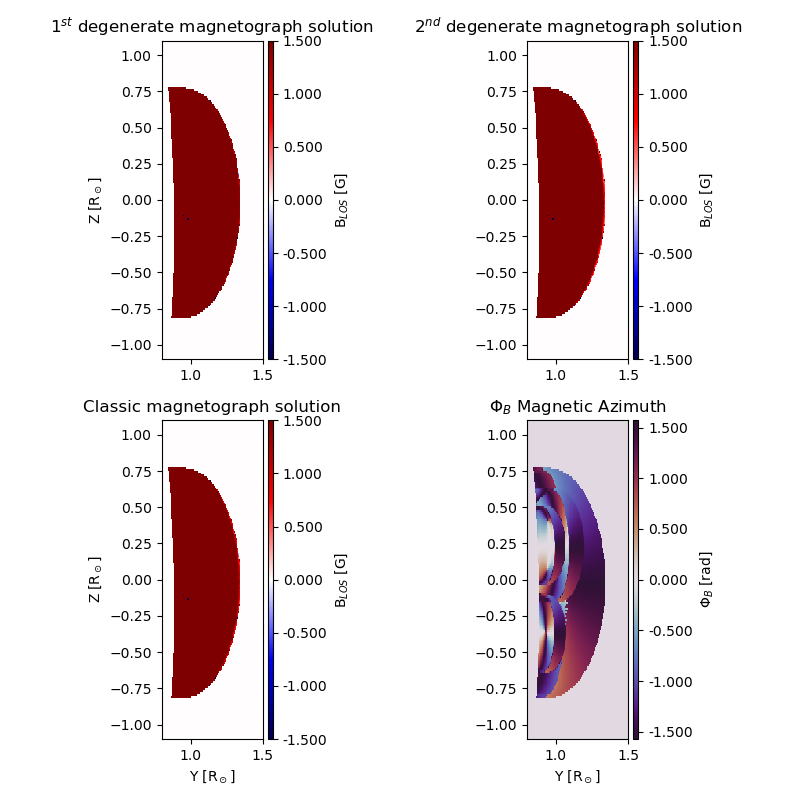

In [18]:
fig, plots = plt.subplots(nrows=2, ncols=2, figsize=(8,8))

ab=plots[0,0].imshow(blosout[srx1:srx2,sry1:sry2,linen,0],extent=rnge,origin='lower',cmap='seismic',interpolation='none',vmin=-1.5,vmax=1.5)
plots[0,0].set_title('1$^{st}$ degenerate magnetograph solution')
colorbar(ab,title="B$_{LOS}$ [G]")
plots[0,0].set_ylabel('Z [R$_\odot$]')
#plots[0,0].set_xlabel('Y [R$_\odot$]')

ab=plots[0,1].imshow(blosout[srx1:srx2,sry1:sry2,linen,1],extent=rnge,origin='lower',cmap='seismic',interpolation='none',vmin=-1.5,vmax=1.5)
plots[0,1].set_title('2$^{nd}$ degenerate magnetograph solution')
colorbar(ab,title="B$_{LOS}$ [G]")
#plots[0,1].set_ylabel('Z [R$_\odot$]')
#plots[0,1].set_xlabel('Y [R$_\odot$]')

ab=plots[1,0].imshow(blosout[srx1:srx2,sry1:sry2,linen,2],extent=rnge,origin='lower',cmap='seismic',interpolation='none',vmin=-1.5,vmax=1.5)
plots[1,0].set_title('Classic magnetograph solution')
colorbar(ab,title="B$_{LOS}$ [G]")
plots[1,0].set_ylabel('Z [R$_\odot$]')
plots[1,0].set_xlabel('Y [R$_\odot$]')

ab=plots[1,1].imshow(blosout[srx1:srx2,sry1:sry2,linen,3],extent=rnge,origin='lower',cmap='twilight_shifted',interpolation='none',vmin=-np.pi/2,vmax=np.pi/2)
plots[1,1].set_title('$\Phi_B$ Magnetic Azimuth')
colorbar(ab,title="$\Phi_B$ [rad]")
plots[1,1].set_xlabel('Y [R$_\odot$]')

plt.tight_layout()

### Save the putput plots
if not os.path.exists('./testrun_outputs'):              ## make an output directory to keep things clean
    os.makedirs('./testrun_outputs')
plt.savefig(f"./testrun_outputs/blosout_1line_{datestamp}.pdf")

### Plot 2-line magnetic inversion outputs

/tmp/ipykernel_1347338/1766833025.py:5: RuntimeWarning: invalid value encountered in log10
  ab=plots[0,0].imshow(np.log10(invout[srx1:srx2,sry1:sry2,soln,0]),extent=rnge,origin='lower',cmap='tab20c',interpolation='none')


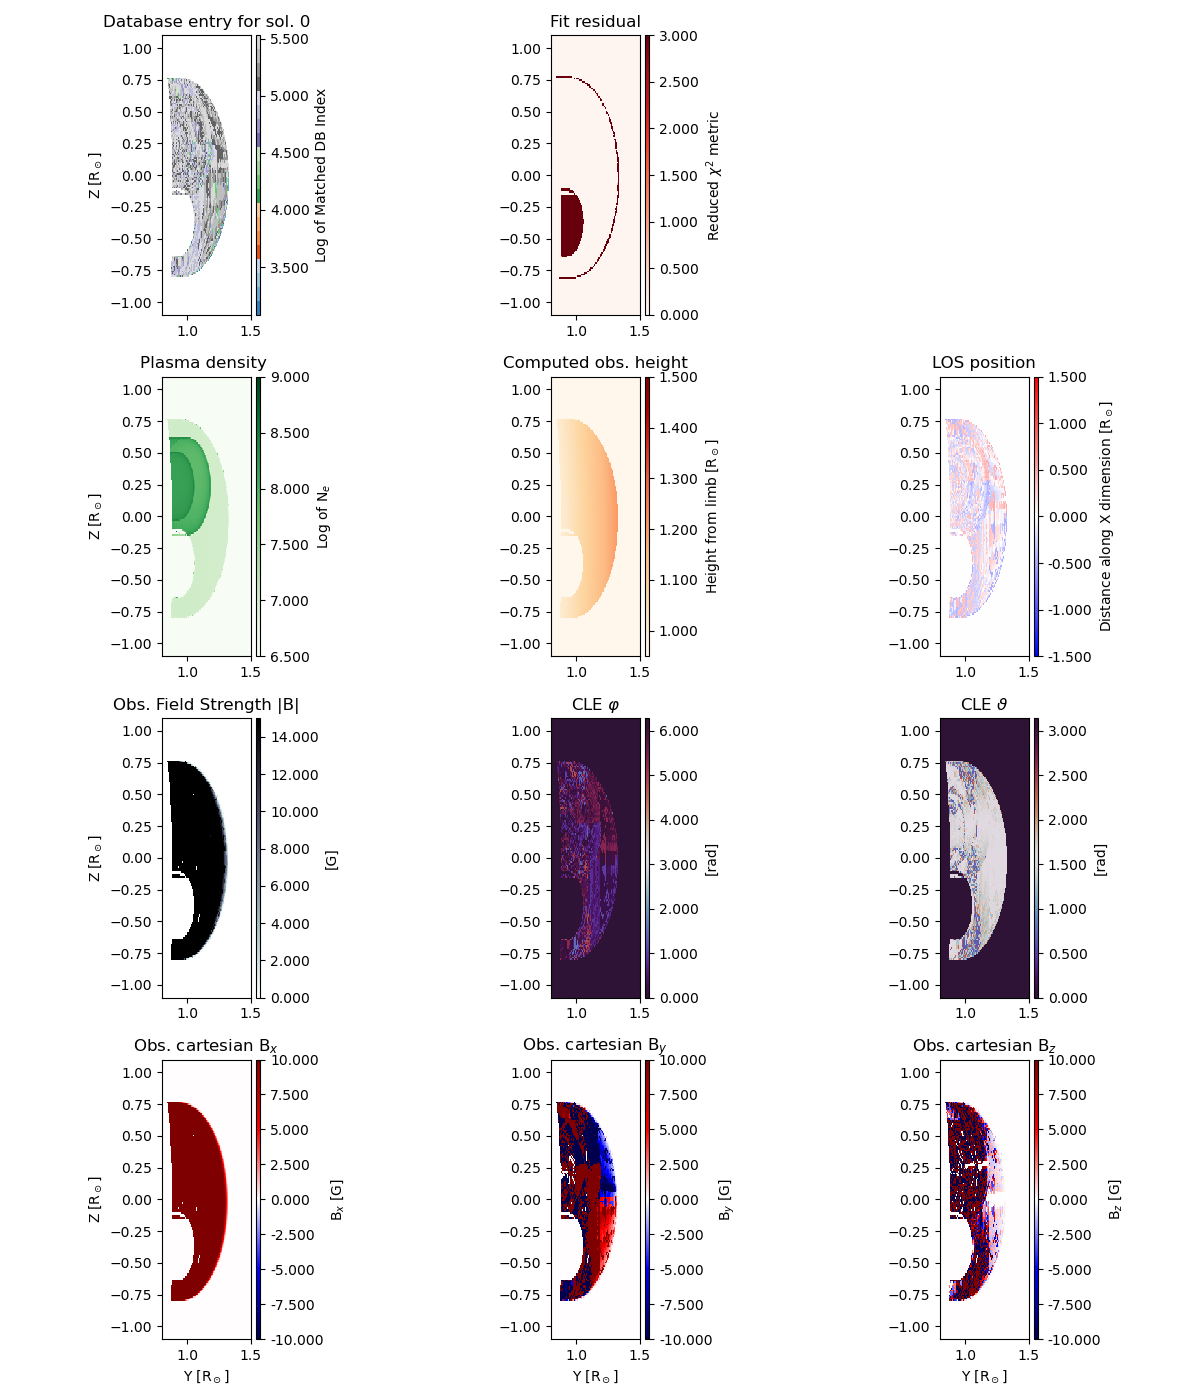

In [59]:
soln=0

fig, plots = plt.subplots(nrows=4, ncols=3, figsize=(12,14))

ab=plots[0,0].imshow(np.log10(invout[srx1:srx2,sry1:sry2,soln,0]),extent=rnge,origin='lower',cmap='tab20c',interpolation='none')
plots[0,0].set_title(f'Database entry for sol. {soln}')
colorbar(ab, title='Log of Matched DB Index')
plots[0,0].set_ylabel('Z [R$_\odot$]')

ab=plots[0,1].imshow(invout[srx1:srx2,sry1:sry2,soln,1],extent=rnge,origin='lower',cmap='Reds',interpolation='none',vmin=0,vmax=3)
plots[0,1].set_title('Fit residual')
colorbar(ab, title='Reduced $\chi^2$ metric')

plots[0, 2].axis('off') ###leave one empty panel

ab=plots[1,0].imshow(invout[srx1:srx2,sry1:sry2,soln,2],extent=rnge,origin='lower',cmap='Greens',interpolation='none',vmin=6.5,vmax=9)
plots[1,0].set_title('Plasma density ')
colorbar(ab, title='Log of N$_e$')
plots[1,0].set_ylabel('Z [R$_\odot$]')

ab=plots[1,1].imshow(invout[srx1:srx2,sry1:sry2,soln,3],extent=rnge,origin='lower',cmap='OrRd',interpolation='none',vmin=0.95,vmax=1.5)
plots[1,1].set_title('Computed obs. height')
colorbar(ab, title='Height from limb [R$_\odot$]')

ab=plots[1,2].imshow(invout[srx1:srx2,sry1:sry2,soln,4],extent=rnge,origin='lower',cmap='bwr',interpolation='none',vmin=-1.5,vmax=1.5)
plots[1,2].set_title('LOS position')
colorbar(ab, title='Distance along X dimension [R$_\odot$]')

mmscale=np.fix(np.abs(2*np.mean(invout[srx1:srx2,sry1:sry2,soln,5])))
ab=plots[2,0].imshow(invout[srx1:srx2,sry1:sry2,soln,5],extent=rnge,origin='lower',cmap='bone_r',interpolation='none',vmin=0,vmax=15)#mmscale)
plots[2,0].set_title('Obs. Field Strength |B|')
colorbar(ab, title='[G]')
plots[2,0].set_ylabel('Z [R$_\odot$]')

ab=plots[2,1].imshow(invout[srx1:srx2,sry1:sry2,soln,6],extent=rnge,origin='lower',cmap='twilight_shifted',interpolation='none',vmin=0,vmax=6.28)
plots[2,1].set_title('CLE $\\varphi$')
colorbar(ab, title='[rad]')

ab=plots[2,2].imshow(invout[srx1:srx2,sry1:sry2,soln,7],extent=rnge,origin='lower',cmap='twilight_shifted',interpolation='none',vmin=0,vmax=3.14)
plots[2,2].set_title('CLE $\\vartheta$ ')
colorbar(ab, title='[rad]')


mmscale=np.fix(np.abs(2*np.mean(invout[srx1:srx2,sry1:sry2,soln,8])))
ab=plots[3,0].imshow(invout[srx1:srx2,sry1:sry2,soln,8],extent=rnge,origin='lower',cmap='seismic',interpolation='none',vmin=-10,vmax=10)#,vmin=-mmscale,vmax=mmscale)
plots[3,0].set_title('Obs. cartesian B$_x$')
colorbar(ab, title='B$_x$ [G]')
plots[3,0].set_ylabel('Z [R$_\odot$]')
plots[3,0].set_xlabel('Y [R$_\odot$]')

mmscale=np.fix(np.abs(2*np.mean(invout[srx1:srx2,sry1:sry2,soln,9])))
ab=plots[3,1].imshow(invout[srx1:srx2,sry1:sry2,soln,9],extent=rnge,origin='lower',cmap='seismic',interpolation='none',vmin=-10,vmax=10)#,vmin=-mmscale,vmax=mmscale)
plots[3,1].set_title('Obs. cartesian B$_y$')
colorbar(ab, title='B$_y$ [G]')
plots[3,1].set_xlabel('Y [R$_\odot$]')

mmscale=np.fix(np.abs(2*np.mean(invout[srx1:srx2,sry1:sry2,soln,10])))
ab=plots[3,2].imshow(invout[srx1:srx2,sry1:sry2,soln,10],extent=rnge,origin='lower',cmap='seismic',interpolation='none',vmin=-10,vmax=10)#vmin=-mmscale,vmax=mmscale)
plots[3,2].set_title('Obs. cartesian B$_z$')
colorbar(ab, title='B$_z$ [G]')
plots[3,2].set_xlabel('Y [R$_\odot$]')

plt.tight_layout()

### Save the putput plots
if not os.path.exists('./testrun_outputs'):              ## make an output directory to keep things clean
    os.makedirs('./testrun_outputs')
plt.savefig(f"./testrun_outputs/invout_2line__sol{soln}_{datestamp}.pdf")

#### Print pixelwise inversion solution in a human readable way

In [ ]:
np.set_printoptions(linewidth=200,suppress=True)   ## Suppress can be set to true to disable exponential notation.
xx=171      ## x pixel position
yy=555      ## y pixel position

# print("||  DB Index    ||    chi^2    ||  ne density ||  y (height) || x(LOS pos.) ||      B      ||    varphi   ||  vartheta   ||     Bx      ||      By     ||     Bz       ||") ###for supress=False
print("||  DB Index         ||    chi^2    ||  ne density    ||  y (height)  ||   x(LOS pos.)   ||      B      ||    varphi      ||   vartheta     ||     Bx       ||      By      ||     Bz       ||") ###for supress=True
print(invout[xx,yy,:,:])

||  DB Index         ||    chi^2    ||  ne density    ||  y (height)  ||   x(LOS pos.)   ||      B      ||    varphi      ||   vartheta     ||     Bx       ||      By      ||     Bz       ||
[[ 44487.              0.00003566      8.991           1.0283334      -0.4            30.419815        4.6774826       0.9424778      -0.8588766     -24.595156       17.880318  ]
 [ 44523.              0.00003566      8.991           1.0283334      -0.4            30.419815        4.6774826       2.1991148      -0.8588766     -24.595156      -17.880318  ]
 [253771.              0.00004318      8.991           1.0283334       0.25            1.9111072       4.153884        2.1293018      -0.8588455      -1.3744409      -1.0127327 ]
 [253739.              0.00004318      8.991           1.0283334       0.25            1.911107        4.153884        1.012291       -0.8588454      -1.3744408       1.0127324 ]
 [ 60597.              0.00004663      8.991           1.0283334      -0.35           15.2193

#### Check the issuemask for the selected pixel

In [61]:
importlib.reload(prepinv)
prepinv.iss_print(issuemask,tline=keyvals[4],xx=xx,yy=yy)

ISS_PRINT: One pixel warnings for line fe-xiii_1074 at location x = 171 and y =555 follow:
Code 1: WARNING: One or more of Stokes I, Q, U are lower than statistical noise SNR threshold.
Code 2: WARNING: Stokes V is lower than statistical noise SNR threshold.
ISS_PRINT: One pixel warnings for line fe-xiii_1079 at location x = 171 and y =555 follow:
Code 1: WARNING: One or more of Stokes I, Q, U are lower than statistical noise SNR threshold.
Code 2: WARNING: Stokes V is lower than statistical noise SNR threshold.


#### Plot where a specific issue occurring over the entire map

ISS_PRINT: A map describing locations with warning code 512 will be returned.
Displaying Code 512: WARNING: Linear polarization azimuth is close to Van-Vleck ambiguity (for 2-line observations).


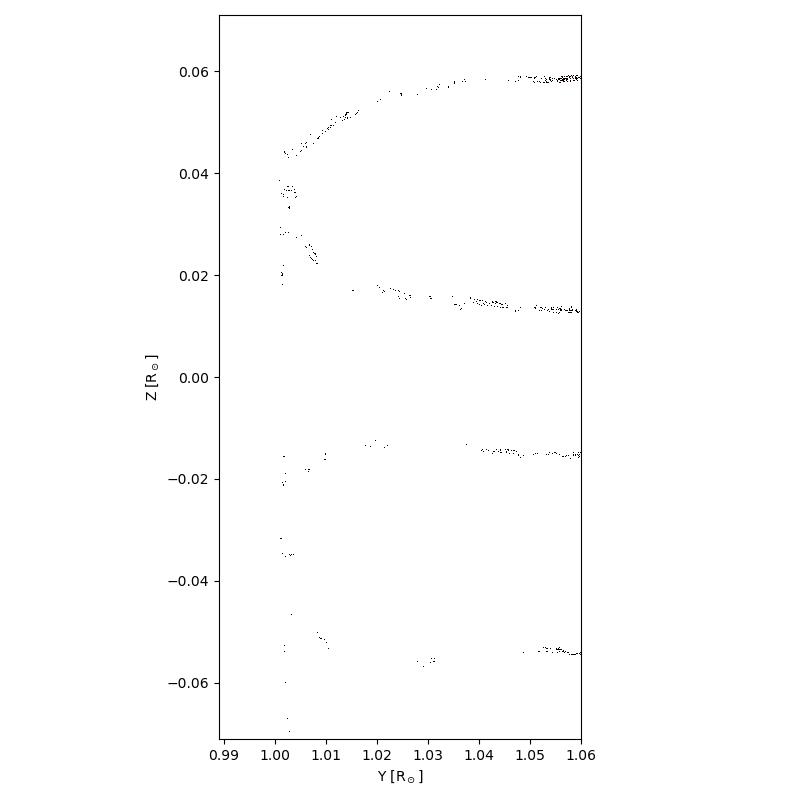

In [73]:
importlib.reload(prepinv)
plt.figure(figsize=[8,8])

issue=512 ## Issue code to plot. see documentation for available codes:

issmap = prepinv.iss_print(issuemask,iss=issue,map1=True)

plt.imshow(issmap,extent=rnge,origin='lower',vmin=0.0,vmax=issue,cmap='hot_r',interpolation='none')

plt.ylabel('Z [R$_\odot$]')
plt.xlabel('Y [R$_\odot$]')


plt.tight_layout()